In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import json
from scipy.stats import percentileofscore

pd.set_option("display.max_columns", None)


In [8]:
exp = pd.read_csv('../ref/CpSilv_gb_annotations_and_expression_data.csv').set_index('Unnamed: 0')
exp = exp[~exp['Beyhan_exp'].isna()]
hyphae_genes = exp[exp['Beyhan_exp']=='hyphae_upreg'].index.drop_duplicates().tolist()
exp.shape

(7301, 23)

In [3]:
gff_path = '../ref/genbank_files/CpSilv.gff3'
gff = pd.read_csv(gff_path, sep='\t', header=None, comment='#')[[0,2,3,4,6,8]]
gff.columns = ['chrom', 'type', 'start', 'stop', 'direction', 'annotation']
gff = gff[(gff['type'] == 'gene')]
gff['gene'] = gff['annotation'].str.split(';',expand=True)[0].str.split("ID=gene-", expand=True)[1]
gff['midpoint'] = gff['start'] + (gff['stop']-gff['start'])/2

gff = gff[gff['gene'].isin(exp.index.tolist())]
gff.shape

(7301, 8)

In [4]:
chr_lens = {'CP075068.1':8340845,
            'CP075069.1':8079863,
            'CP075070.1':6494557,
            'CP075071.1':3437093,
            'CP075072.1':1489275}

#function to assign genes to windows based on their midpoints

def get_genes_in_window(window_start, window_size, chrom, gff):
    
    temp = gff[gff['chrom']==chrom]    
    temp = temp[temp['midpoint'].between(window_start, window_start+window_size)]['gene'].tolist()
    return [g for g in temp if g in exp.index.tolist()]

hyphae_gff = gff[gff['gene'].isin(hyphae_genes)]

In [5]:
#divide genome into windows

window_size = 25000

chr_windows = {}

for chrom, chrom_len in chr_lens.items():
    chr_windows[chrom] = np.arange(0, chrom_len, window_size)
    
gene_windows = []
gene_windows_by_chrom = {}

for chrom in chr_windows:
    for window in chr_windows[chrom]:
        genes_in_window = get_genes_in_window(window, window_size, chrom, gff)
        if genes_in_window:
            gene_windows += [genes_in_window]
    gene_windows_by_chrom[chrom] = gene_windows


In [10]:
threshold = 6
n = 10000
np.random.seed(100)
hyphae_genes = exp[exp['Beyhan_exp']=='hyphae_upreg'].index.drop_duplicates().tolist()


###REAL WINDOW COUNTS
real_high_hyphae_gene_areas = []

for window in gene_windows:
    hyphae_genes_in_window = [gene for gene in window if gene in hyphae_genes]
    if len(hyphae_genes_in_window) >= threshold:
        real_high_hyphae_gene_areas += [window]
print('real count of windows with at least {} hyphae-upregulated genes: {}'.format(threshold, len(real_high_hyphae_gene_areas)))        
     

###BOOTSTRAPPED WINDOW COUNTS
bootstrap_high_hyphae_gene_areas = []
num_hyphae_genes = len(hyphae_genes)
all_genes = exp.index.drop_duplicates().to_numpy()

for i in range(n):
    
    if i % 1000 == 0:
        print(i)
    
    randomized_hyphae_genes = np.random.choice(all_genes, num_hyphae_genes, replace=False)
    windows_at_or_over_threshold = 0
    for window in gene_windows:
        hyphae_genes_in_window = [gene for gene in window if gene in randomized_hyphae_genes]
        
        if len(hyphae_genes_in_window) >= threshold:
            windows_at_or_over_threshold += 1
            
    bootstrap_high_hyphae_gene_areas += [windows_at_or_over_threshold]
            
bootstrap_high_hyphae_gene_areas = sorted(bootstrap_high_hyphae_gene_areas)
real_count_percentile = percentileofscore(bootstrap_high_hyphae_gene_areas, len(real_high_hyphae_gene_areas), kind='mean')
real_count_percentile

real count of windows with at least 6 hyphae-upregulated genes: 4


99.285

In [11]:
1-.99285

0.00714999999999999

### Plotting

In [12]:
hyphae_color1 = '#cc9d58'
hyphae_color2 = '#806134'

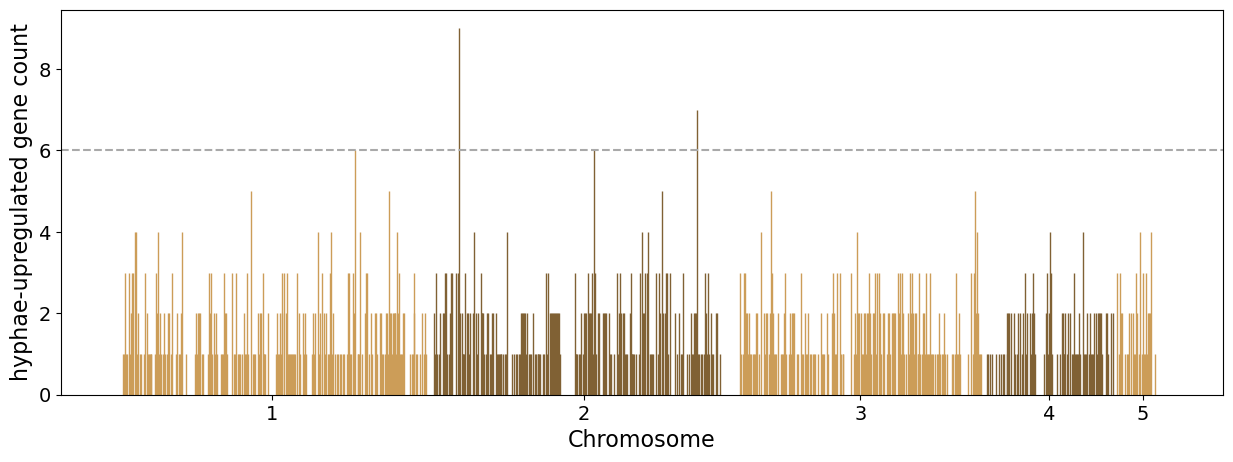

In [13]:
#divide genome into windows

chr_windows = {}

for chrom, chrom_len in chr_lens.items():
    chr_windows[chrom] = np.arange(0, chrom_len, window_size)

gene_windows_by_chrom = {}

for chrom in chr_windows:
    gene_windows = []
    for window in chr_windows[chrom]:
        genes_in_window = get_genes_in_window(window, window_size, chrom, hyphae_gff)
        gene_windows += [genes_in_window]
            
    gene_windows_by_chrom[chrom] = gene_windows

plt.figure(figsize=(15,5))

cumulative_chrom_lengths = [0]
for i, (chrom, chrom_len) in enumerate(chr_lens.items()):
    
    if i%2 == 0:
        color = hyphae_color1
    else:
        color = hyphae_color2

    x = [i+cumulative_chrom_lengths[-1] for i in chr_windows[chrom]]
    y = [len(g) for g in gene_windows_by_chrom[chrom]]
    
    plt.bar(x,y, ec=color)
    
    cumulative_chrom_lengths += [chrom_len+cumulative_chrom_lengths[-1]]
    
plt.axhline(y=threshold, color='darkgray', linestyle='--')
    
xtick_pos = [np.mean([cumulative_chrom_lengths[i], cumulative_chrom_lengths[i+1]]) for i in range(5)]
plt.xticks(xtick_pos,np.arange(1,6), fontsize=14)
plt.xlabel('Chromosome', fontsize=16)
plt.ylabel('hyphae-upregulated gene count', fontsize=16)
plt.yticks(fontsize=14)
plt.savefig('../figures/fig2B_raw.png', dpi=300)
plt.show()    

### Save genes and their locations to file (Table S2)

In [14]:
window_size = 25000
all_window_genes = []
windows = []
chr_windows = {}

for chrom, chrom_len in chr_lens.items():
    chr_windows[chrom] = np.arange(0, chrom_len, window_size)
    
gene_windows = []

for chrom in chr_windows:
    for window in chr_windows[chrom]:
        genes_in_window = get_genes_in_window(window, window_size, chrom, gff)
        if genes_in_window:
            gene_windows += [genes_in_window]
            
for window in gene_windows:
    hyphae_genes_in_window = [gene for gene in window if gene in hyphae_genes]
    if len(hyphae_genes_in_window) >= threshold:
        all_window_genes += window
        windows += [window]

In [16]:
gene_info = gff[gff['gene'].isin(all_window_genes)][['gene', 'chrom', 'start', 'stop', 'annotation']]
gene_info = gene_info.merge(exp['Beyhan_exp'], left_on='gene', right_index=True)
gene_info = gene_info.rename(columns={'Beyhan_exp':'expression (Mandel et al 2022)'})

chr_nums = {'CP075068.1':1,
            'CP075069.1':2,
            'CP075070.1':3,
            'CP075071.1':4,
            'CP075072.1':5}

gene_info = gene_info.replace({"chrom": chr_nums})

gene_window_dict = {}
window_num = 1
for gene in all_window_genes:
    if gene in windows[window_num-1]:
        gene_window_dict[gene] = str(window_num)
    else:
        window_num += 1
        gene_window_dict[gene] = str(window_num)
        
        
gene_info['window_number'] = gene_info['gene'].map(gene_window_dict)
gene_info = gene_info[['window_number']+list(gene_info.columns[:-1])]

gene_info.to_csv('../tables/TableS2_hyphae.csv', index=False)